Total # images to process = 10


$$$Reading Image img/0009.jpg
Original Image (842, 1268, 3)


Image Smoothing
shape (842, 1268, 3)


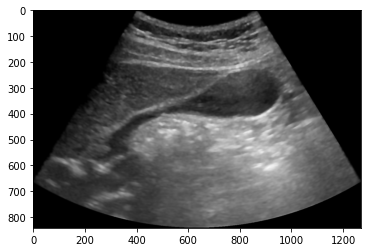

Improved contrast
shape (842, 1268)


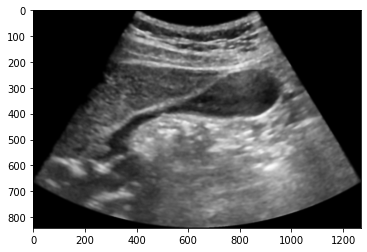

Erode Image
shape (842, 1268)


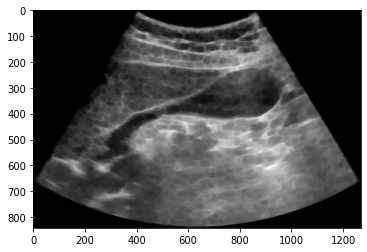

shape (842, 1268)


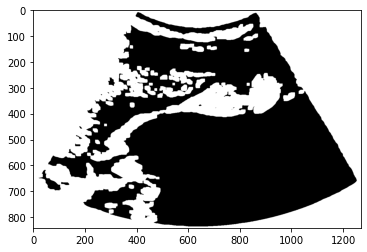

Thresholding
Close and Erode operations
shape (842, 1268)


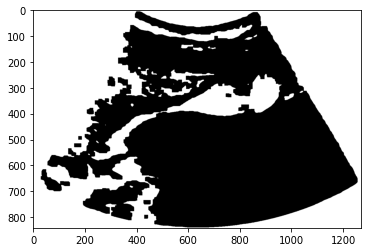

Canny Edge Detection
Find all contours and Extract Gallbladder
shape (842, 1268)


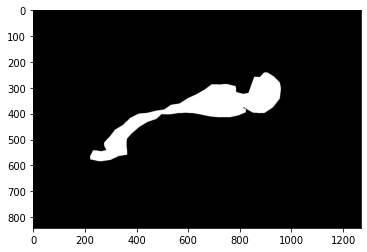

saving mask: det/0009.png


In [2]:
import os
import cv2 as cv
import json
from glob import glob
import numpy as np
import argparse
import matplotlib.pyplot as plt

def show_image(img, name="default",save=False):
    if img is None:
        print('Could not open or find the image: ', args.input)
        exit(0)
    else:
        '''cv2.imshow('image', image)
        cv2.waitKey(0)
        cv2.destroyAllWindows()'''
        print("shape", img.shape)
        fig = plt.figure(0)
        plt.imshow(img, cmap='gray')
        plt.show()
        if save:
            fig.savefig("plots/"+name+".png", dpi=300, format="png")        
    return
def save_mask(name, mask):
    pth = os.path.join(det_path,name+".png")
    print("saving mask:",pth)
    cv.imwrite(pth,mask)



def generate_mask(img):
    print("\n\n$$$Reading Image", img)
    orig_image = cv.imread(img)
    (H,W,C) = orig_image.shape
    print("Original Image", orig_image.shape)
    #show_image(orig_image)
    
    image = cv.bilateralFilter(orig_image, d=9,sigmaColor=100,sigmaSpace=100,borderType=cv.BORDER_REPLICATE)
    print("\n\nImage Smoothing")
    show_image(image)
    clahe = cv.createCLAHE(clipLimit=1, tileGridSize=(8,8))
    imp_cont_image = clahe.apply(cv.cvtColor(image,cv.COLOR_BGR2GRAY))
    print("Improved contrast")
    
    imp_cont_smt_image = cv.bilateralFilter(imp_cont_image, d=9,sigmaColor=100,sigmaSpace=100,borderType=cv.BORDER_REPLICATE)
    #print("Improved contrast + Smoothed")
    
    show1 = cv.hconcat([cv.cvtColor(image, cv.COLOR_BGR2GRAY),imp_cont_image, imp_cont_smt_image])
    show_image(imp_cont_smt_image)

    erode_img = cv.erode(imp_cont_smt_image, cv.getStructuringElement(cv.MORPH_RECT,(5,5)), iterations=2) 
    print("Erode Image")
    show_image(erode_img)

    ret, th_img = cv.threshold(erode_img,60,255,cv.THRESH_BINARY_INV)
    show3 = cv.hconcat([erode_img, th_img])
    show_image(th_img)
    print("Thresholding")

    #open = cv.morphologyEx(canny_edges, cv.MORPH_OPEN, cv.getStructuringElement(cv.MORPH_RECT,(3,3)), iterations = 1) 
    open_close = cv.morphologyEx(th_img, cv.MORPH_CLOSE, cv.getStructuringElement(cv.MORPH_RECT,(3,3)), iterations = 2) 
    
    open_close = cv.erode(open_close, cv.getStructuringElement(cv.MORPH_RECT,(5,5)), iterations=2)
    show4 = cv.hconcat([th_img, open_close])
    print("Close and Erode operations")
    show_image(open_close)

    canny_edges = cv.Canny(open_close,threshold1=45, threshold2=45,apertureSize=3,L2gradient=False)

    show2 = cv.hconcat([open_close, canny_edges])
    #show_image(show2, "Close Canny", True)
    print("Canny Edge Detection")

    contours, hierarchy = cv.findContours(open_close, cv.RETR_CCOMP, cv.CHAIN_APPROX_NONE)
    print("Find all contours and Extract Gallbladder")

    #print(len(contours))
    ctr = sorted(contours, key=cv.contourArea) 
    big_ctr = ctr[-5:]
    filtered_big_ctr = []
    for c in big_ctr:
        area = cv.contourArea(c)
        #print("Area",area)
        if area > 10000 and area < 150000:
            filtered_big_ctr.append(c)
    
    filtered_big_ctr = sorted(filtered_big_ctr, key=cv.contourArea)
    gb_ctr = filtered_big_ctr[-1]
    output = np.zeros((H,W))
    poly_mask_gb = []
    sampler = 33
    for i in range(int(len(gb_ctr)/sampler)):
        poly_mask_gb.append(gb_ctr[i*sampler])
    poly_mask_gb.append(gb_ctr[-1])

    cv.drawContours(output, [np.array(poly_mask_gb)], -1, (255,255,255), -1)
    output = cv.dilate(output, cv.getStructuringElement(cv.MORPH_RECT,(5,5)), iterations=3)
       
    show_image(output)
    save_mask(img.split("/")[-1][:-4], output)

    return contours, hierarchy

if __name__ == "__main__":
   
    
    img_path = "img"
    det_path = "det"
    images = glob(os.path.join(img_path,"*.jpg"))

    print("Total # images to process =", len(images))

    #for img in images:
    '''for img in images:
        ctr, hrcy = generate_mask(img)'''
    ctr, hrcy = generate_mask(images[9])

In [ ]:
orig = cv.imread("img/0005.jpg")
show_image(orig)
image = cv.bilateralFilter(orig, d=9,sigmaColor=120,sigmaSpace=120,borderType=cv.BORDER_REPLICATE)
clahe = cv.createCLAHE(clipLimit=0.5, tileGridSize=(8,8))
#show_image(image)
imp_cont_image = clahe.apply(cv.cvtColor(image,cv.COLOR_BGR2GRAY))

#show_image(imp_cont_image)
'''ret, th_img = cv.threshold(imp_cont_image,60,255,cv.THRESH_BINARY_INV)
ret, th_img_o = cv.threshold(image,65,255,cv.THRESH_BINARY_INV)
show_image(th_img_o)
show_image(th_img)'''

th2 = cv.adaptiveThreshold(imp_cont_image,255,cv.ADAPTIVE_THRESH_MEAN_C,\
            cv.THRESH_BINARY,5,2)
th3 = cv.adaptiveThreshold(imp_cont_image,255,cv.ADAPTIVE_THRESH_GAUSSIAN_C,\
            cv.THRESH_BINARY,5,2)
th2 = cv.bilateralFilter(th2, d=9,sigmaColor=120,sigmaSpace=120,borderType=cv.BORDER_REPLICATE)
th3 = cv.bilateralFilter(th3, d=9,sigmaColor=120,sigmaSpace=120,borderType=cv.BORDER_REPLICATE)
th2 = cv.morphologyEx(th2, cv.MORPH_OPEN, cv.getStructuringElement(cv.MORPH_RECT,(3,3)), iterations = 1) 
th3 = cv.morphologyEx(th3, cv.MORPH_OPEN, cv.getStructuringElement(cv.MORPH_RECT,(3,3)), iterations = 1) 
contours, hierarchy = cv.findContours(th2, cv.RETR_CCOMP, cv.CHAIN_APPROX_NONE)
ctr = sorted(contours, key=cv.contourArea) 
big_ctr = ctr[-5:]
filtered_big_ctr = []
for c in big_ctr:
    area = cv.contourArea(c)
    #print("Area",area)
    if area > 10000 and area < 150000:
        filtered_big_ctr.append(c)
    
filtered_big_ctr = sorted(filtered_big_ctr, key=cv.contourArea)
gb_ctr = filtered_big_ctr[-1]
output = np.zeros((orig.shape[0],orig.shape[1]))
poly_mask_gb = []
sampler = 33
for i in range(int(len(gb_ctr)/sampler)):
    poly_mask_gb.append(gb_ctr[i*sampler])
poly_mask_gb.append(gb_ctr[-1])

cv.drawContours(output, [np.array(poly_mask_gb)], -1, (255,255,255), -1)
output = cv.dilate(output, cv.getStructuringElement(cv.MORPH_RECT,(5,5)), iterations=3)

show_image(output, save=True)


In [ ]:
orig = cv.imread("img/0005.jpg")
blur = cv.GaussianBlur(orig,(5,5),0)

# find normalized_histogram, and its cumulative distribution function
hist = cv.calcHist([blur],[0],None,[256],[0,256])
hist_norm = hist.ravel()/hist.max()
Q = hist_norm.cumsum()

bins = np.arange(256)

fn_min = np.inf
thresh = -1

for i in xrange(1,256):
    p1,p2 = np.hsplit(hist_norm,[i]) # probabilities
    q1,q2 = Q[i],Q[255]-Q[i] # cum sum of classes
    b1,b2 = np.hsplit(bins,[i]) # weights

    # finding means and variances
    m1,m2 = np.sum(p1*b1)/q1, np.sum(p2*b2)/q2
    v1,v2 = np.sum(((b1-m1)**2)*p1)/q1,np.sum(((b2-m2)**2)*p2)/q2

    # calculates the minimization function
    fn = v1*q1 + v2*q2
    if fn < fn_min:
        fn_min = fn
        thresh = i

# find otsu's threshold value with OpenCV function
ret, otsu = cv.threshold(blur,0,255,cv.THRESH_BINARY+cv.THRESH_OTSU)
show_image(otsu)